# **A Deep Learning Based Feature Fusion Method for Automatic Classification of Malaria Parasite using Blood Smear Images**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 27558 train and 27558 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [7]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [133]:
import zipfile

import os

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from keras.utils import to_categorical

import tensorflow as tf

from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

### <b>Let us load the data</b>

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [3]:
import pathlib

dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
data_dir = tf.keras.utils.get_file('cell_images.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

353452851/353452851 ━━━━━━━━━━━━━━━━━━━━ 43s 0us/step


In [9]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name.

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model.

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [10]:
# Storing the path of the extracted "train" folder
train_dir = '/content/cell_images'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [11]:
images_path = os.listdir('/content/cell_images/Parasitized/')
print(len(images_path))

13780


In [12]:
for folder_name in ['/Parasitized/', '/Uninfected/']:

    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:

            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/Parasitized/':

                train_labels.append(1)

            else:

                train_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [13]:
# Storing the path of the extracted "test" folder
test_dir = '/content/cell_images/'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [14]:
for folder_name in ['/Parasitized/', '/Uninfected/']:

    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/Parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b> Check the shape of train and test images

In [10]:
# Shape of images
test_images.shape, train_images.shape

((27558, 64, 64, 3), (27558, 64, 64, 3))

###<b> Check the shape of train and test labels

In [15]:
# Shape of labels
test_labels.shape, train_labels.shape

((27558,), (27558,))

####<b> Observations and insights:
#### After the inital data pre-processing, we were able to list out the shape of training and testing images, also training and testing labels. Their respective shapes were listed above.





### <b>Check the minimum and maximum range of pixel values for train and test images

In [16]:

#type(train_images[0])
pixels = train_images
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))


Data Type: uint8
Min: 0.000, Max: 255.000


####<b> Observations and insights: The pixels are range from 0 to 255



###<b> Count the number of values in both uninfected and parasitized

In [17]:

import os

parasitized_values = sum(len(parasitized) for parasitized in train_dir)
print(parasitized_values)


20


In [18]:
uninfected_values = sum(len(uninfected) for uninfected in train_dir)
print(uninfected_values)

20


###<b>Normalize the images

In [19]:
train_images = (train_images/255).astype('float32')

test_images = (test_images/255).astype('float32')

####<b> Observations and insights: Now, the pixel values of images are normalized from 0-255 to 0-1

###<b> Plot to check if the data is balanced

<Axes: ylabel='Count'>

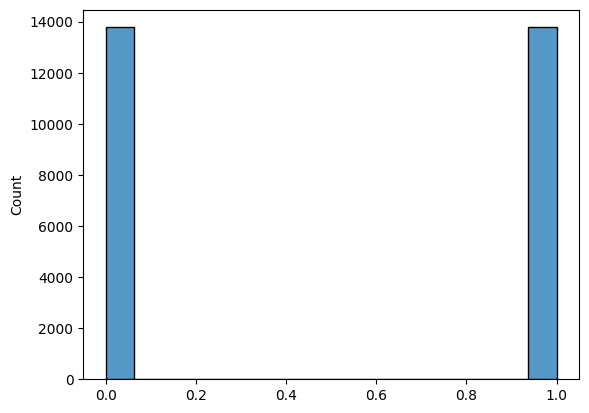

In [20]:
from seaborn.distributions import histplot
# You are free to use bar plot or pie-plot or count plot, etc. to plot the labels of train and test data and check if they are balanced
histplot(train_labels)



<Axes: ylabel='Count'>

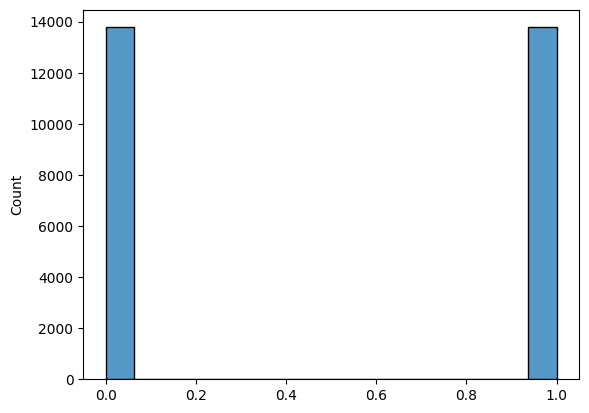

In [21]:
from seaborn.distributions import histplot
# You are free to use bar plot or pie-plot or count plot, etc. to plot the labels of train and test data and check if they are balanced
histplot(train_labels)


####<b> Observations and insights:  It's obvious from above plots that train and test labels are balanced in the data.

### <b>Data Exploration</b>
Let's visualize the images from the train data

<ipython-input-22-5dbbd68ab4ab>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.random.randint(0, train_images.shape[0], 1))


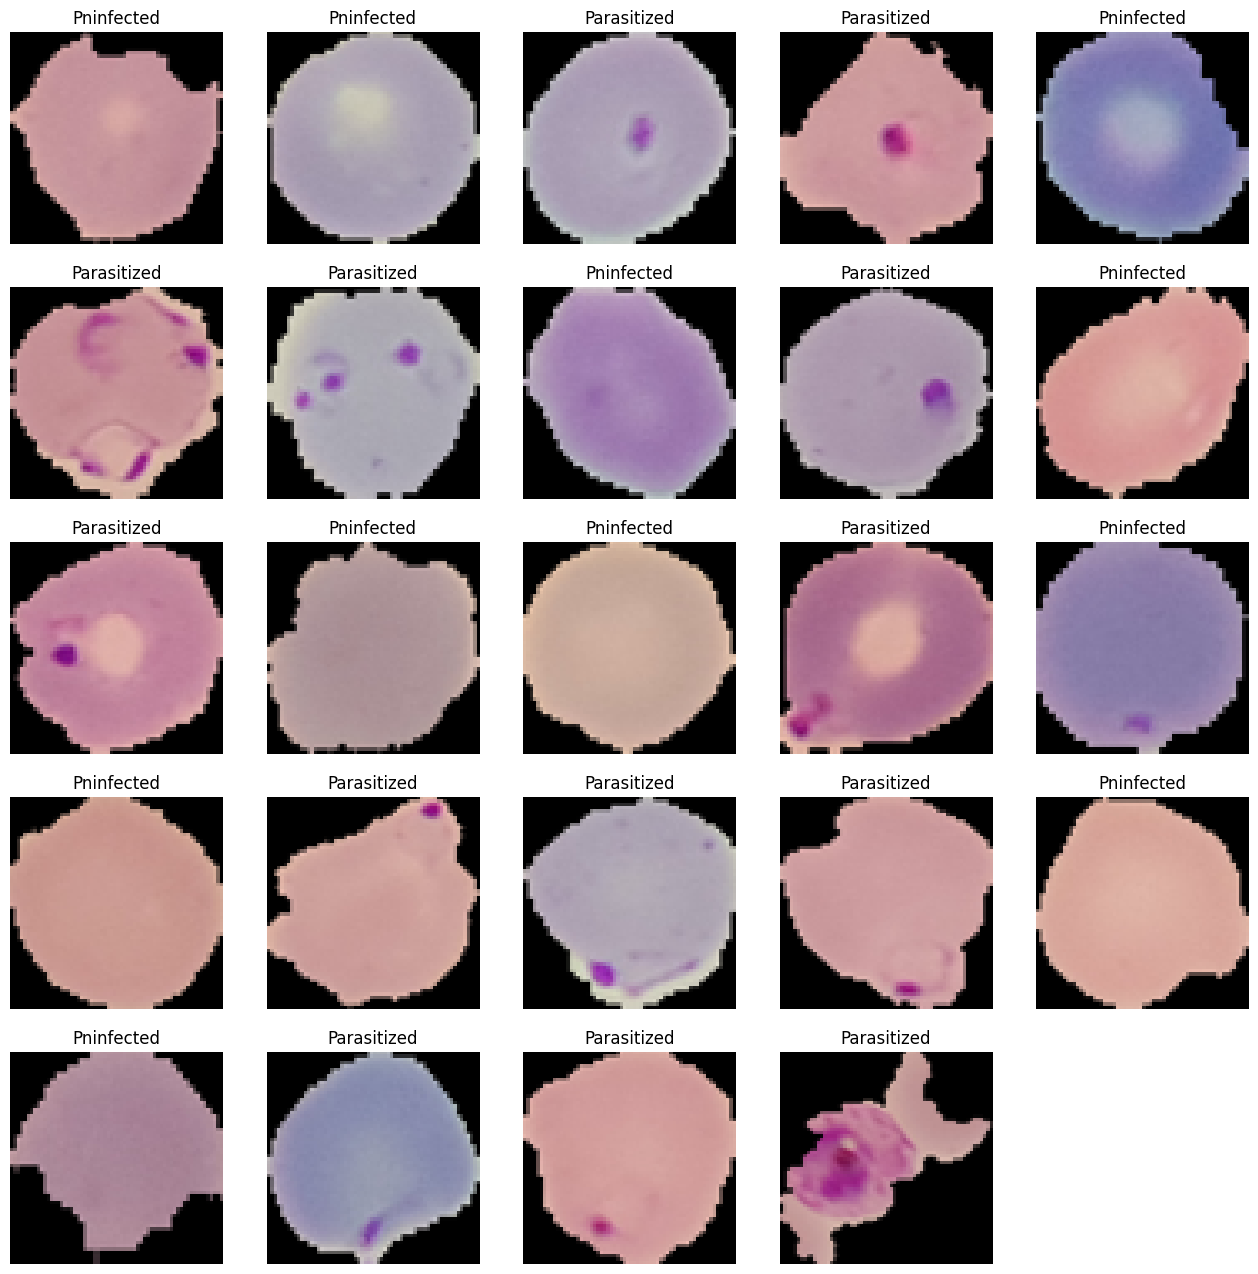

In [22]:
np.random.seed(42)

plt.figure(1, figsize = (16 , 16))

for n in range(1, 25):

    plt.subplot(5, 5, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('Parasitized')

    else:
        plt.title('Pninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

####<b> Observations and insights:  Observations and insights: From above images, I would say that image with some form a distrubances inbetween the cell or to say some different colour comapred to the overall cell, if see that it is said to be parasitized, otherwise it's uninfected.

###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

<ipython-input-23-beb105a6b791>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(np.random.randint(0, train_images.shape[0], 1))


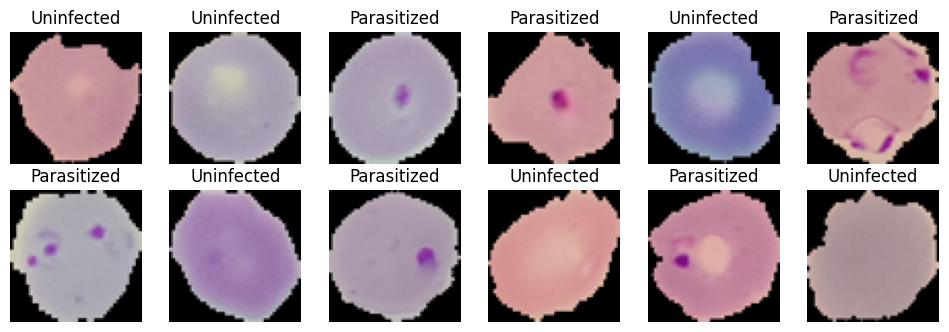

In [23]:
np.random.seed(42)

plt.figure(1, figsize = (12 , 12))

for n in range(1, 13):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1:

        plt.title('Parasitized')

    else:
        plt.title('Uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')



####<b>Observations and insights:

###<b> Plotting the mean images for parasitized and uninfected

In [24]:
def find_mean_img(full_mat, title):

    # Calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]

    # Reshape it back to a matrix
    plt.imshow(mean_img)

    plt.title(f'Average {title}')

    plt.axis('off')

    plt.show()

    return mean_img

<b> Mean image for parasitized

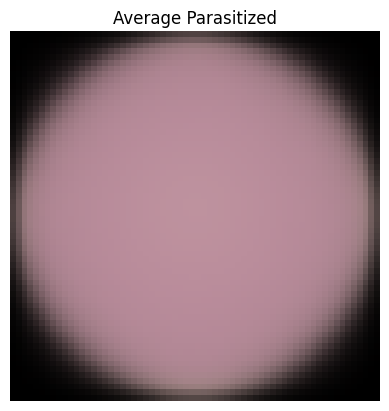

In [25]:
parasitized_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 1:

              parasitized_data.append([img])

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean


<b> Mean image for uninfected

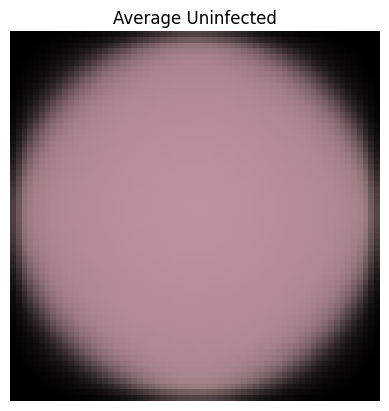

In [26]:


uninfected_data = []  # Create a list to store the uninfected data

for img, label in zip(train_images, train_labels):

        if label == 1:

              uninfected_data.append([img])

uninfected_mean = find_mean_img(np.array(uninfected_data), 'Uninfected')   # find the mean




####<b> Observations and insights: The mean image for both parasitized and uninfected are pretty much same because, the diffence between these two images are very small (infection is the only difference). The average image is obviously the larger part of it and how it seems most likely is the idea.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

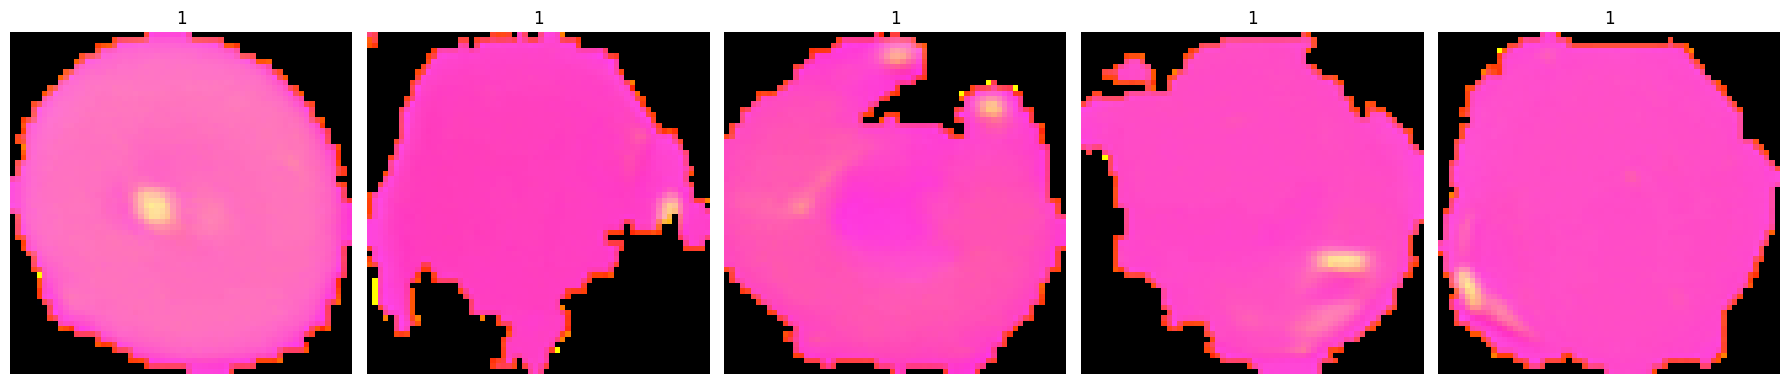

In [27]:
import cv2

gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)

  gfx.append(a)

gfx = np.array(gfx)




viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Converting the test data

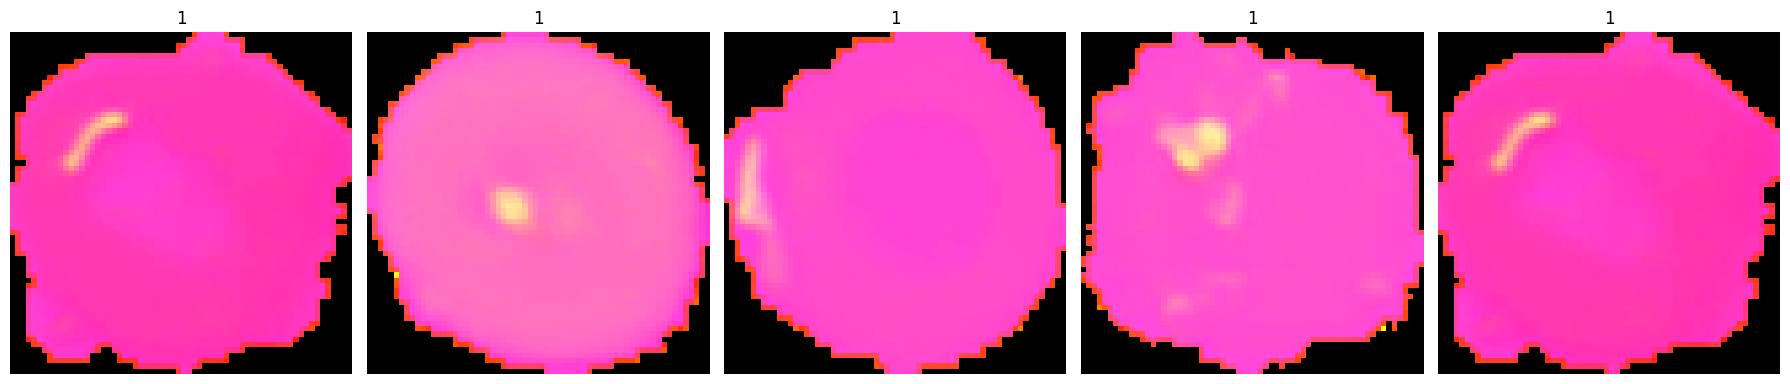

In [28]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

####<b>Observations and insights: We were able to plot the training and testing images with HSV

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

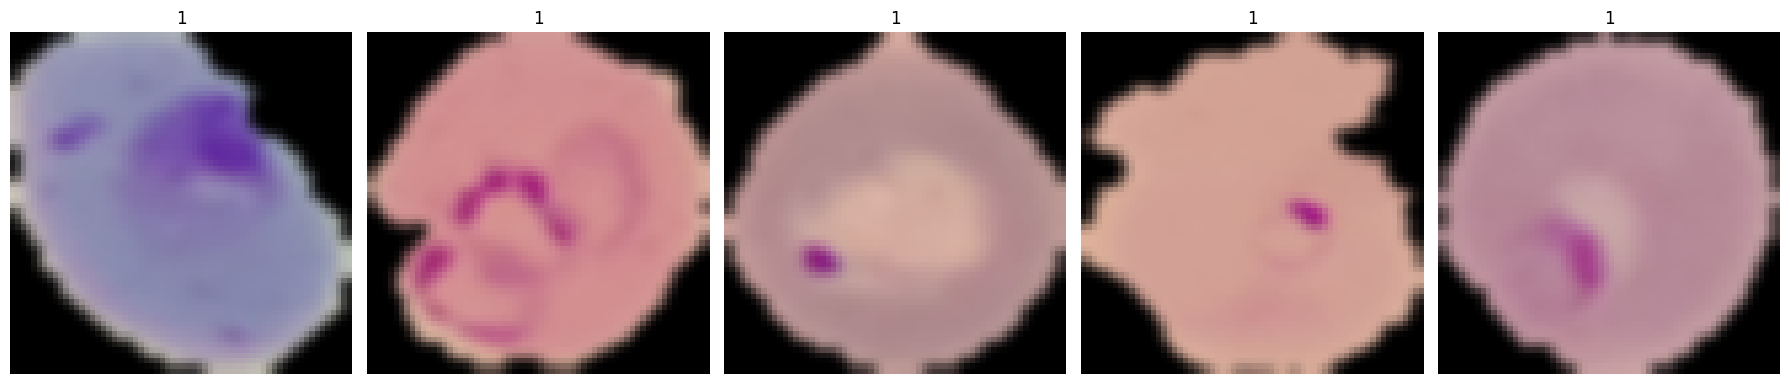

In [29]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)


viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

###<b> Gaussian Blurring on test data

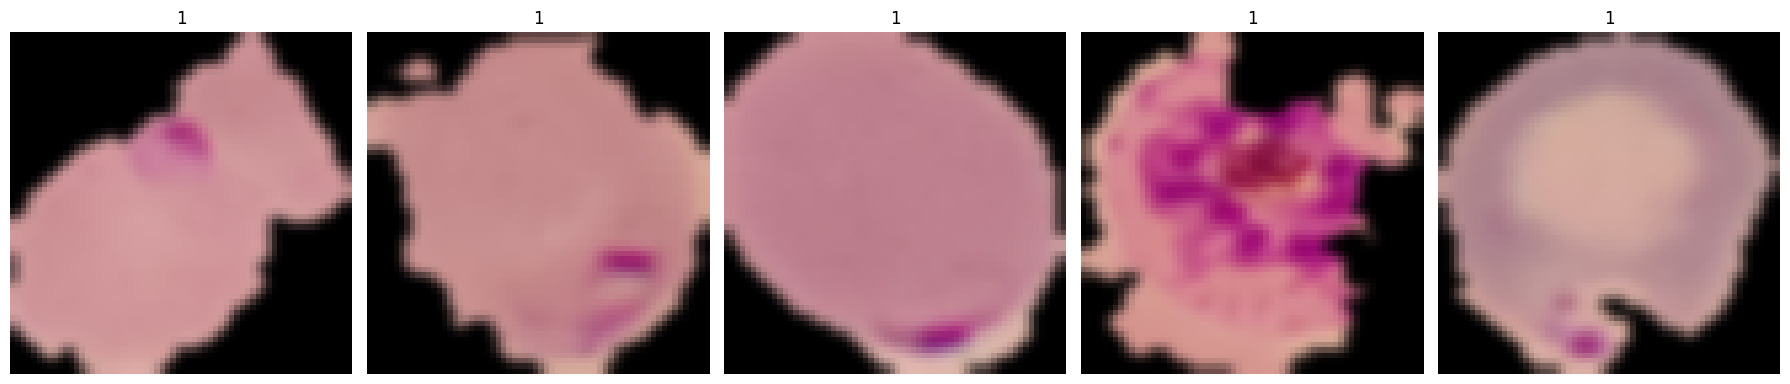

In [30]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(test_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)


viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)


  ax[t].imshow(gbx[i])

  ax[t].set_axis_off()

  fig.tight_layout()

####**Observations and insights: I don't think blurring would help us, since we are classifing an image, that too a infection in an organism, which is very small, by blurring we might loose information like newly formed bacteria, which is very tiny or at the beginning stage**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [31]:
# Clearing backend
import tensorflow as tf

from tensorflow.keras import backend

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from random import shuffle

backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

####<B>One Hot Encoding the train and test labels

In [32]:
# Encoding Train Labels
from keras.utils import to_categorical
train_labels = to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 2)

###<b> Building the model

In [33]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu", input_shape = (64, 64, 3))) # input shape of ( 64, 64, 3 ) 3 represents the channels RGB

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))

# model.add(MaxPooling2D(pool_size = 2))

# model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation = "relu")) # A fully connected layer

model.add(Dropout(0.4))

model.add(Dense(128, activation = "relu")) # A fully connected layer

model.add(Dropout(0.5))

model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,229,154 (8.50 MB)

 Trainable params: 2,229,154 (8.50 MB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [35]:
#modeCheckPoint = ModelCheckpoint('/mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)
#print(modeCheckPoint)

checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
modeCheckP = ModelCheckpoint(filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
print(modeCheckP)

In [36]:
#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('/mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5),ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]


<b> Fit and train our Model

In [37]:
history = model.fit(train_images, train_labels, batch_size = 256, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6306 - loss: 0.6481 - val_accuracy: 0.9184 - val_loss: 0.4388
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9198 - loss: 0.2378 - val_accuracy: 0.9146 - val_loss: 0.2835
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9501 - loss: 0.1613 - val_accuracy: 0.9410 - val_loss: 0.2202
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9531 - loss: 0.1436 - val_accuracy: 0.9376 - val_loss: 0.1981
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9562 - loss: 0.1366 - val_accuracy: 0.9468 - val_loss: 0.1922
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9540 - loss: 0.1371 - val_accuracy: 0.9456 - val_loss: 0.1941
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9561 - loss: 0.1291 - val_accuracy: 0.9470 - val_loss: 0.1722
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9583 - loss: 0.1221 - val_accuracy: 0.9501 -

###<b> Evaluating the model on test data

In [38]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9722 - loss: 0.0708

 Test_Accuracy:- 0.9628419876098633


<b> Plotting the confusion matrix

862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     13779
           1       0.95      0.97      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



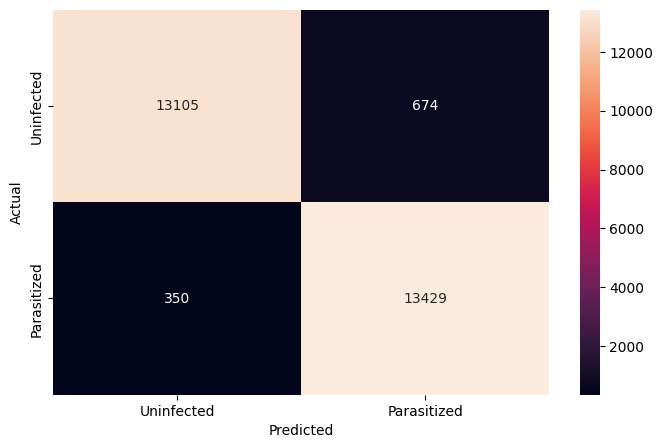

In [39]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b>Plotting the train and validation curves

In [40]:
# Function to plot train and validation accuracy
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

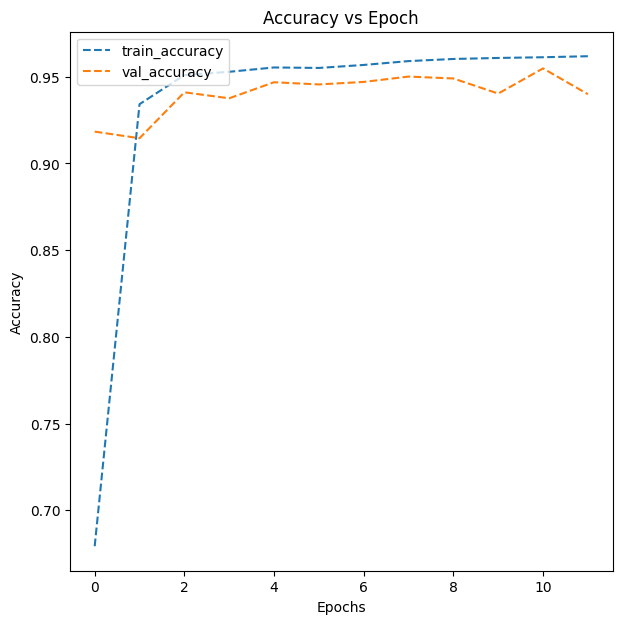

In [41]:
plot_accuracy(history)

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [42]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [43]:
# Creating sequential model

from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam



model1 = Sequential()

# Build the model here and add new layers


model1.add(Conv2D(filters = 64, kernel_size = (2,2), strides = (1,1), padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model1.add(MaxPooling2D(pool_size = 2))


model1.add(Conv2D(filters = 64, kernel_size =(2,2), strides = (1,1), padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))


model1.add(Conv2D(filters = 64, kernel_size = (2,2), strides =(1,1), padding = "valid", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = "relu"))

model1.add(MaxPooling2D(pool_size = 2))

model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(256, activation = "relu"))

model1.add(Dense(256, activation = "relu"))

model1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,242 (711.88 KB)

 Trainable params: 182,242 (711.88 KB)

 Non-trainable params: 0 (0.00 B)

###<b> Compiling the model

In [44]:
adam = optimizers.Adam(learning_rate = 0.001)
model1.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

<b> Using Callbacks

In [45]:
#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]



<b>Fit and Train the model

In [46]:
history1 = model1.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 10, verbose = 1)


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.6986 - loss: 0.5528 - val_accuracy: 0.9492 - val_loss: 0.2502
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9520 - loss: 0.1467 - val_accuracy: 0.9414 - val_loss: 0.2659
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9570 - loss: 0.1413 - val_accuracy: 0.9565 - val_loss: 0.1897
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9588 - loss: 0.1306 - val_accuracy: 0.9619 - val_loss: 0.1632
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9592 - loss: 0.1248 - val_accuracy: 0.9614 - val_loss: 0.1516
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9614 - loss: 0.1211 - val_accuracy: 0.9601 - val_loss: 0.1528
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9606 - loss: 0.1164 - val_accuracy: 0.9595 - val_loss: 0.1527


###<b> Evaluating the model

In [47]:
accuracy1 = model1.evaluate(test_images, test_labels,verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy1[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9585 - loss: 0.1110

 Test_Accuracy:- 0.9612090587615967


<b> Plotting the confusion matrix

862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     13779
           1       0.96      0.96      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



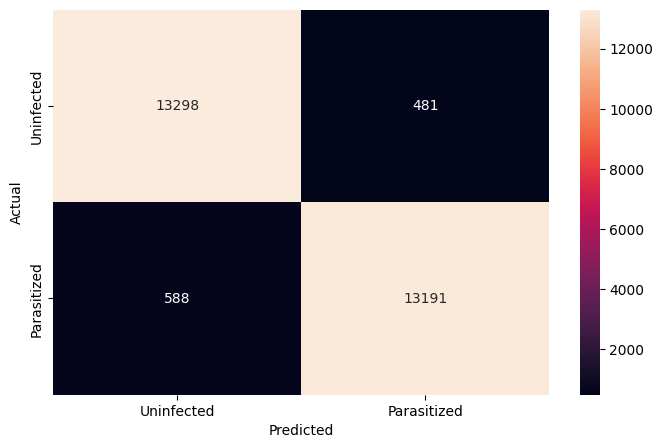

In [48]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model1.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Plotting the train and the validation curves

In [49]:
def plot_accuracy(history):

    N = len(history1.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history1.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history1.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

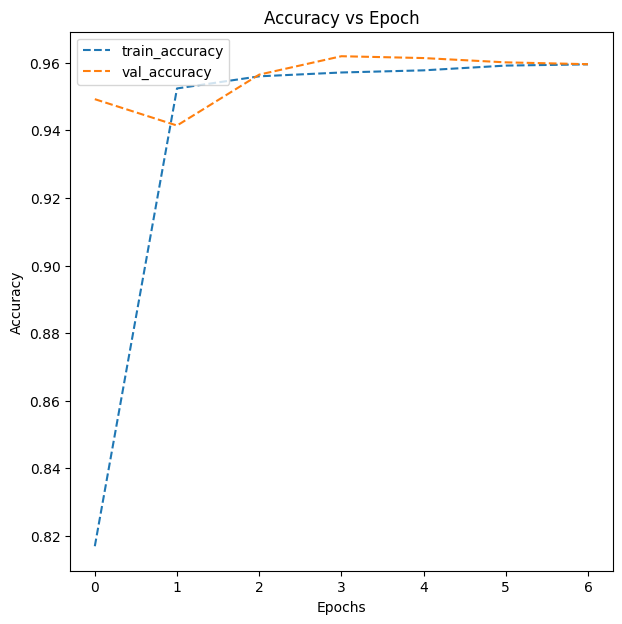

In [50]:
plot_accuracy(history)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [51]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [52]:
from tensorflow.keras.layers import  LeakyReLU, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))

model2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model2.add(MaxPooling2D(pool_size = 2))

model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(512, activation = "relu"))

model2.add(BatchNormalization())

model2.add(Dense(2, activation = "relu")) # 2 represents output layer neurons

model2.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,060,834 (4.05 MB)

 Trainable params: 1,059,810 (4.04 MB)

 Non-trainable params: 1,024 (4.00 KB)

###<b>Compiling the model

In [53]:
from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import Adam

adam = optimizers.Adam(learning_rate = 0.001)

model2.compile(loss = "CategoricalCrossentropy", optimizer = adam, metrics = ['accuracy']) # using loss as caategoriacal _cross entropy since we are using Leaky Relu

<b> Using callbacks

In [54]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2)
,ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]
#             , ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [55]:
history2 = model2.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4949 - loss: nan - val_accuracy: 0.0773 - val_loss: nan
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5149 - loss: nan - val_accuracy: 0.0728 - val_loss: nan
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5006 - loss: nan - val_accuracy: 0.2297 - val_loss: nan


<b>Plotting the train and validation accuracy

In [56]:

def plot_accuracy(history):

    N = len(history2.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history2.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history2.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

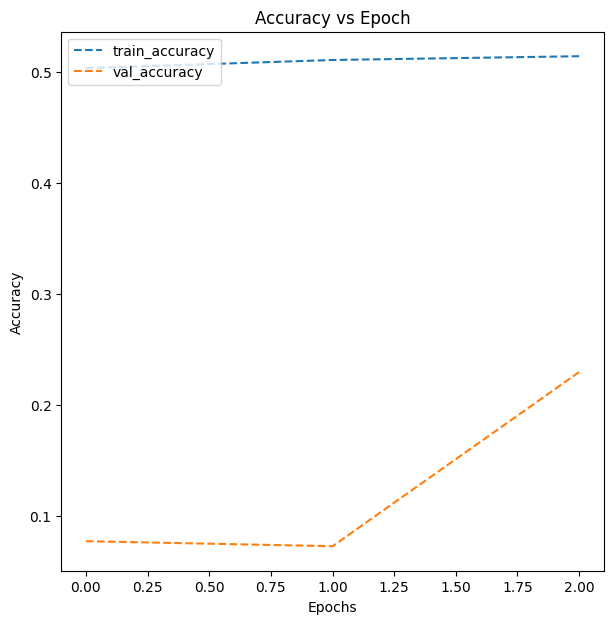

In [57]:
plot_accuracy(history)

###<b>Evaluating the model

In [58]:
# Evaluate the model to calculate the accuracy

accuracy = model2.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6551 - loss: nan

 Test_Accuracy:- 0.48080411553382874


####<b>Observations and insights: The performance of the model has droppped significantly, after changing the activation function from softmax to LeakyRelu.

<b> Generate the classification report and confusion matrix

862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.46      0.22      0.30     13779
           1       0.49      0.74      0.59     13779

    accuracy                           0.48     27558
   macro avg       0.47      0.48      0.44     27558
weighted avg       0.47      0.48      0.44     27558



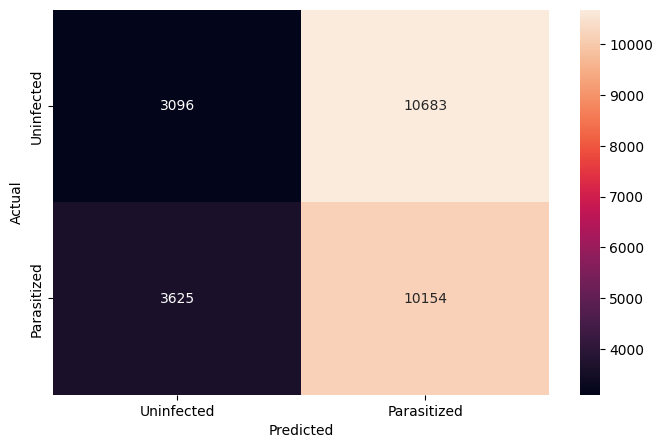

In [59]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix

cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [60]:
backend.clear_session() # Clearing backend for new model

###<b> Use image data generator

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator( horizontal_flip = True, vertical_flip=True, height_shift_range=0.1, width_shift_range=0.1,
                                  zoom_range = 0.5, rotation_range = 30)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = train_images, y = train_labels, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = test_images, y = test_labels, batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

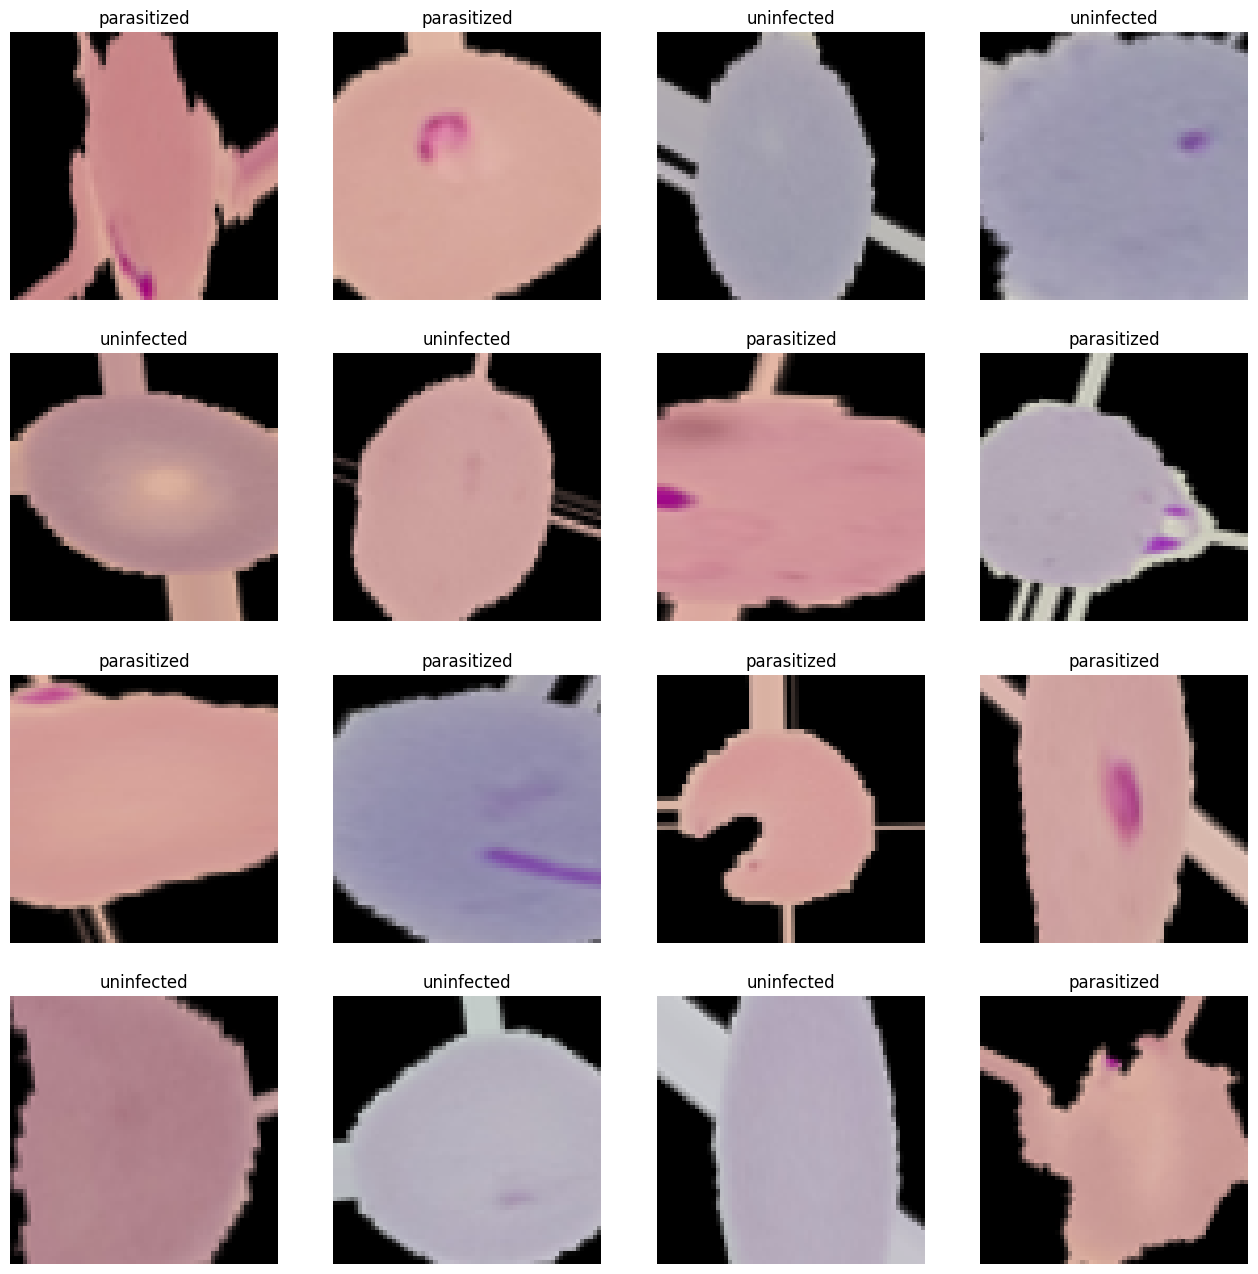

In [62]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1:

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

####<b>Observations and insights:  We are loosing the information with data augumentation, when some images are enlarged we are loosing the parasitized information, which is crucial in our classification

###<b>Building the Model

In [59]:
from keras import optimizers

In [63]:
model3 = Sequential()

# Build the model here
model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))

model3.add(MaxPooling2D(pool_size = 2))

model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512, activation = "relu"))

model3.add(Dropout(0.4))

model3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model3.compile(loss = 'binary_crossentropy' , optimizer = adam, metrics = ['accuracy'])

model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,786 (4.04 MB)

 Trainable params: 1,058,786 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

<b>Using Callbacks

In [64]:
#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2), ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]


<b> Fit and Train the model

In [65]:
history3 = model3.fit(train_generator,
                                  validation_data = val_generator,
                                  batch_size = 128, callbacks = callbacks,
                                  epochs = 20, verbose = 1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


431/431 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.6013 - loss: 0.6560 - val_accuracy: 0.9324 - val_loss: 0.2192
Epoch 2/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.8934 - loss: 0.2791 - val_accuracy: 0.9542 - val_loss: 0.1787
Epoch 3/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9079 - loss: 0.2559 - val_accuracy: 0.9548 - val_loss: 0.1651
Epoch 4/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9164 - loss: 0.2440 - val_accuracy: 0.9534 - val_loss: 0.1584
Epoch 5/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9216 - loss: 0.2323 - val_accuracy: 0.9494 - val_loss: 0.1570
Epoch 6/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9209 - loss: 0.2313 - val_accuracy: 0.9491 - val_loss: 0.1649
Epoch 7/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9218 - loss: 0.2287 - val_accuracy: 0.9553 - val_loss: 0.1462
Epoch 8/20
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.9221 - loss: 0.2233 - val_accurac

###<B>Evaluating the model

In [66]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9338 - loss: 0.2219

 Test_Accuracy:- 0.9520647525787354


<b>Plot the train and validation accuracy

In [67]:
# Potting the accuracies


def plot_accuracy(history):

    N = len(history3.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history3.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history3.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")


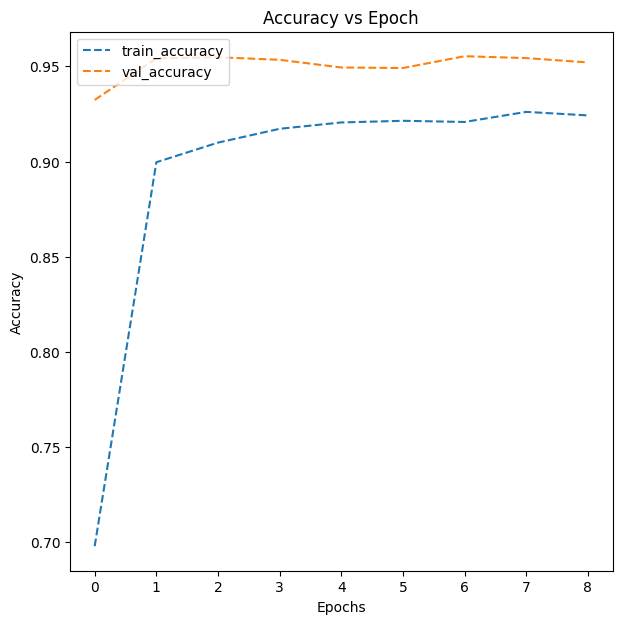

In [68]:
plot_accuracy(history)

<B>Plotting the classification report and confusion matrix

862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     13779
           1       0.98      0.93      0.95     13779

    accuracy                           0.95     27558
   macro avg       0.95      0.95      0.95     27558
weighted avg       0.95      0.95      0.95     27558



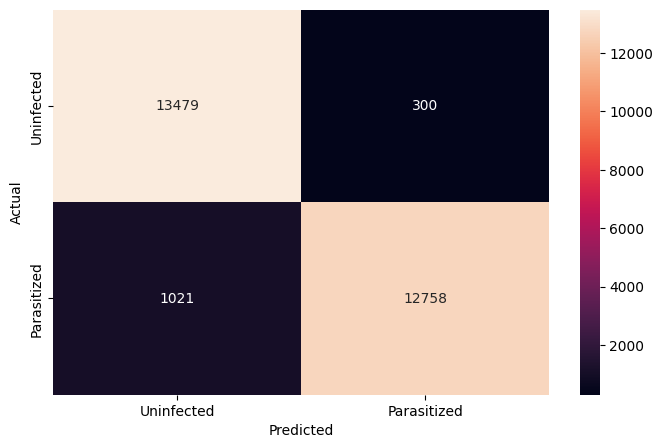

In [69]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [70]:
# Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.layers import BatchNormalization

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [71]:
from tensorflow.keras.applications.vgg19 import VGG19

from tensorflow.keras import Model

vgg = VGG19(include_top = False, weights = 'imagenet', input_shape = (64, 64, 3))

vgg.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
transfer_layer = vgg.get_layer('block3_pool')

vgg.trainable = False

# Add classification layers on top of it
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a dense layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model4 = Model(vgg.input, pred) # Initializing the model

###<b>Compiling the model

In [73]:
# Compiling the model
model4.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.00051),
              metrics = ['accuracy'])

<b> using callbacks

In [74]:
# Adding Callbacks to the model
#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
#             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
            ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]

<b>Fit and Train the model

In [75]:
# Fitting the model and running the model for 10 epochs
#final_history = final_model.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)
history4 = model4.fit(train_generator, validation_data = val_generator, epochs = 5, callbacks = callbacks, batch_size = 128, validation_split = 0.2,verbose = 1)

Epoch 1/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.7829 - loss: 0.4624 - val_accuracy: 0.7640 - val_loss: 0.5572
Epoch 2/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.8595 - loss: 0.3348 - val_accuracy: 0.7897 - val_loss: 0.4566
Epoch 3/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.8691 - loss: 0.3146 - val_accuracy: 0.9245 - val_loss: 0.2166
Epoch 4/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.8752 - loss: 0.3036 - val_accuracy: 0.8810 - val_loss: 0.2865
Epoch 5/5
431/431 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.8731 - loss: 0.3084 - val_accuracy: 0.9164 - val_loss: 0.2447


In [76]:
# The genrealization gap is quite high for the VGG16 model.

# Evaluating the model on test data
accuracy4 = model4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy4[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9513 - loss: 0.1349

 Test_Accuracy:- 0.9164307713508606


<b>Plot the train and validation accuracy

In [77]:
# plotting the accuracies
def plot_accuracy(history):

    N = len(history4.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history4.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history4.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")



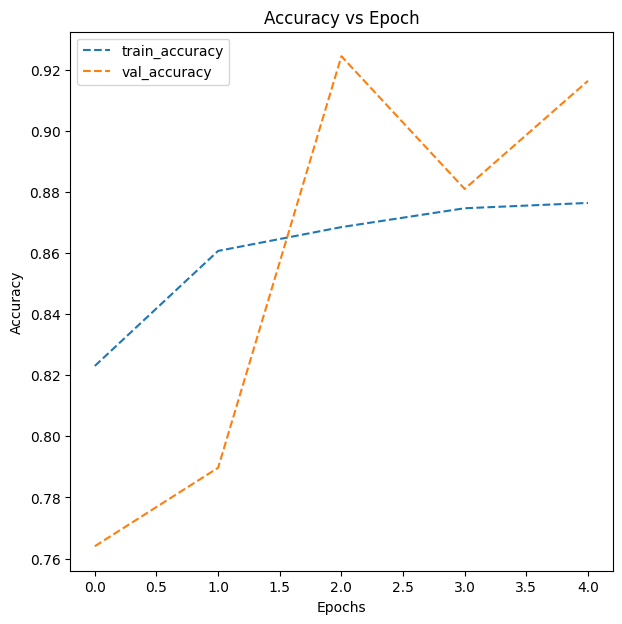

In [78]:
plot_accuracy(history)

###**Observations and insights: **

*   What can be observed from the validation and train curves?

I used 5 epoch for the VGG16  model, since it's quite time conusming, the performance might increase if I would have used 10 epochs.

###<b> Evaluating the model

In [79]:

# Evaluating the model on test data

accuracy = model4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9513 - loss: 0.1349

 Test_Accuracy:- 0.9164307713508606


<b>Plotting the classification report and confusion matrix

862/862 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     13779
           1       0.88      0.97      0.92     13779

    accuracy                           0.92     27558
   macro avg       0.92      0.92      0.92     27558
weighted avg       0.92      0.92      0.92     27558



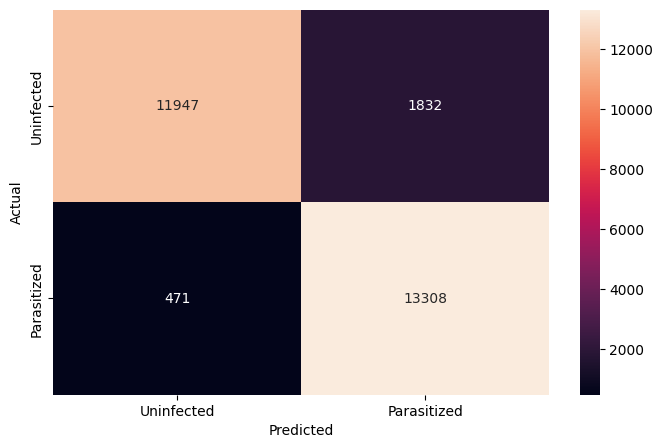

In [80]:
# Plot the confusion matrix and generate a classification report for the model
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?

From the confusion matrix, I've noticed that, A model with low false negative and low false positive rates has high accuracy.

*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [ ]:
backend.clear_session() # Clearing backend for new model

In [81]:
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras import layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam



final_model = Sequential()

# Build the model here and add new layers

final_model.add(Conv2D(filters = 128, kernel_size = (2,2), strides = (1,1), padding = "same", activation = "relu", input_shape = (64, 64, 3)))
final_model.add(MaxPooling2D(pool_size = 2))


final_model.add(Conv2D(filters = 128, kernel_size =(2,2), strides = (1,1), padding = "same", activation = "relu"))

final_model.add(MaxPooling2D(pool_size = 2))


final_model.add(Conv2D(filters = 128, kernel_size = (2,2), strides =(1,1), padding = "valid", activation = "relu"))

final_model.add(MaxPooling2D(pool_size = 2))

final_model.add(Dropout(0.2))

final_model.add(Conv2D(filters = 64, kernel_size =(2,2), strides = (1,1), padding = "same", activation = "relu"))

final_model.add(MaxPooling2D(pool_size = 2))


final_model.add(Dropout(0.2))

final_model.add(Conv2D(filters = 32, kernel_size = (2,2), padding = "same", activation = "relu"))

final_model.add(MaxPooling2D(pool_size = 2))

final_model.add(Dropout(0.2))

final_model.add(Flatten())

final_model.add(Dense(512, activation = "relu"))
final_model.add(Dense(256, activation = "relu"))
final_model.add(Dense(256, activation = "relu"))

final_model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons

final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 32)       │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,578 (1.48 MB)

 Trainable params: 388,578 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
adam = optimizers.Adam(learning_rate = 0.0001)
final_model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [83]:
#callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
#ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
ModelCheckpoint(filepath='/tmp/ckpt/checkpoint.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)]

In [84]:
final_history = final_model.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.6224 - loss: 0.6577 - val_accuracy: 0.7485 - val_loss: 0.8987
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9233 - loss: 0.3723 - val_accuracy: 0.9272 - val_loss: 0.2453
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9426 - loss: 0.1657 - val_accuracy: 0.9497 - val_loss: 0.1844
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9509 - loss: 0.1419 - val_accuracy: 0.9614 - val_loss: 0.1547
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9550 - loss: 0.1341 - val_accuracy: 0.9585 - val_loss: 0.1579
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9554 - loss: 0.1308 - val_accuracy: 0.9624 - val_loss: 0.1498
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9575 - loss: 0.1264 - val_accuracy: 0.9617 - val_loss: 0.1514
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9583 - loss: 0.1226 - val_acc

In [85]:
accuracy = final_model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9571 - loss: 0.1133

 Test_Accuracy:- 0.96197110414505


862/862 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     13779
           1       0.97      0.95      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



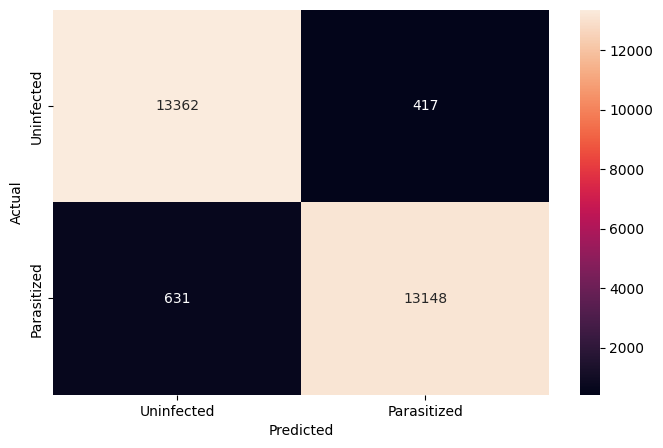

In [86]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = final_model.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

In [87]:
def plot_accuracy(history):

    N = len(final_history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), final_history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), final_history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

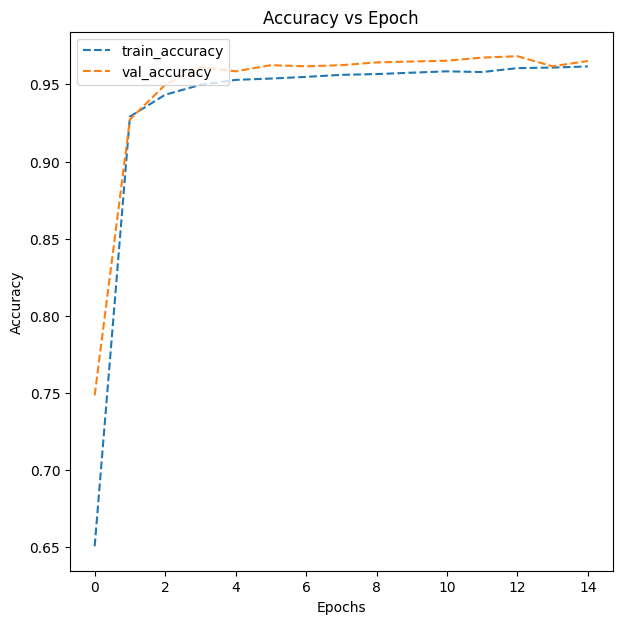

In [88]:
plot_accuracy(final_history)

####<b> Observations and Conclusions drawn from the final model:



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?

With the VGG16 model, I've tried with different architectures, but it is not able to perform well on our data.

*  You can try to build a model using these HSV images and compare them with your other models.



In [ ]:
backend.clear_session() # Clearing backend for new model

**ResNet50V2 Model**

In [89]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import Input

image_input_shape = Input(shape=(64, 64, 3))
resnetv2 = ResNet50V2(input_tensor=image_input_shape, include_top=False, weights='imagenet')

# do not train the existing weights
for layer in resnetv2.layers:
    layer.trainable = False

# defining input and output to the model
x = Flatten()(resnetv2.output)
x = Dense(128, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)

modelResNet50V2 = Model(inputs = resnetv2.input, outputs= prediction)
# view the structure of the model
modelResNet50V2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 16, 16,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 16, 16,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 18, 18,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 16, 16,    │          0 │ conv2_block1_0_c

 Total params: 24,613,762 (93.89 MB)

 Trainable params: 1,048,962 (4.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [90]:
# Compiling the model
modelResNet50V2.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0005),
              metrics = ['accuracy'])

In [91]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    )
]

In [92]:
resNet50V2_history = modelResNet50V2.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_200']
Received: inputs=Tensor(shape=(None, 64, 64, 3))
  warnings.warn(msg)


173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8299 - loss: 0.5055 - val_accuracy: 0.8378 - val_loss: 0.3893 - learning_rate: 5.0000e-04
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9029 - loss: 0.2355 - val_accuracy: 0.8472 - val_loss: 0.3735 - learning_rate: 5.0000e-04
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9130 - loss: 0.2101 - val_accuracy: 0.8443 - val_loss: 0.3810 - learning_rate: 5.0000e-04
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9211 - loss: 0.1932 - val_accuracy: 0.8436 - val_loss: 0.3848 - learning_rate: 5.0000e-04
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9295 - loss: 0.1772 - val_accuracy: 0.8815 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9334 - loss: 0.1708 - val_accuracy: 0.8795 - val_loss: 0.3053 - learning_rate: 1.0000e-04
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9

In [93]:
accuracy = modelResNet50V2.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9412 - loss: 0.1504

 Test_Accuracy:- 0.96197110414505


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_200']
Received: inputs=Tensor(shape=(32, 64, 64, 3))
  warnings.warn(msg)


862/862 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     13779
           1       0.90      0.95      0.92     13779

    accuracy                           0.92     27558
   macro avg       0.92      0.92      0.92     27558
weighted avg       0.92      0.92      0.92     27558



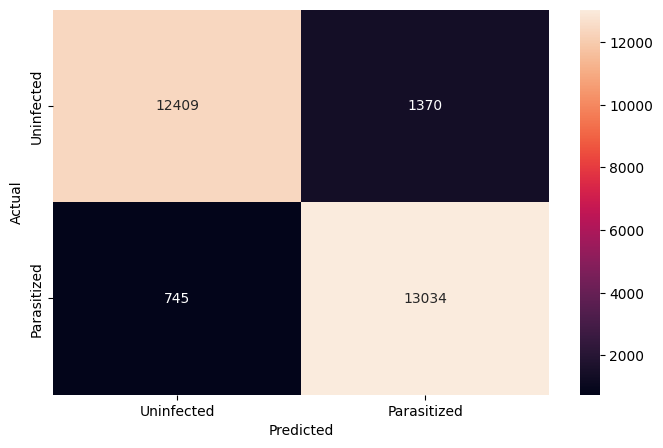

In [94]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = modelResNet50V2.predict(test_images)

pred = np.argmax(pred, axis = 1)

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

In [95]:
def plot_accuracy(history):

    N = len(resNet50V2_history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), resNet50V2_history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), resNet50V2_history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")

    plt.xlabel("Epochs")

    plt.ylabel("Accuracy")

    plt.legend(loc="upper left")

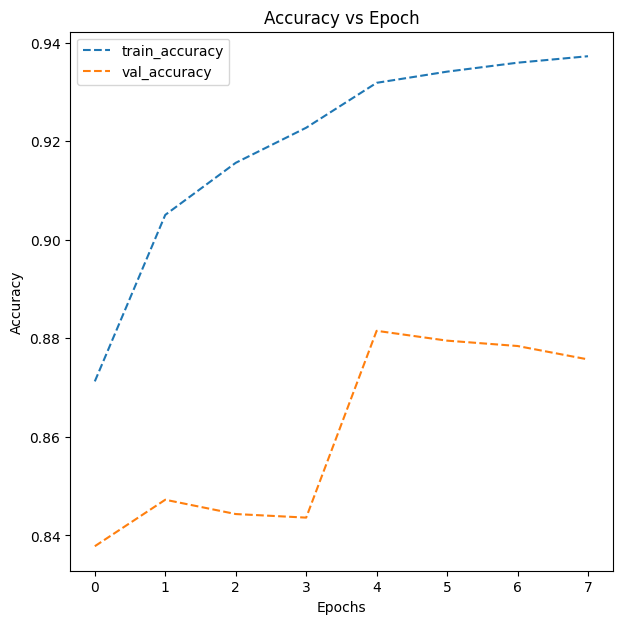

In [96]:
plot_accuracy(final_history)

In [145]:
backend.clear_session() # Clearing backend for new model

In [146]:
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2


def conv2d_bn(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   use_bias=False,
                   kernel_regularizer=l2(weight_decay)
                   )(x)
    layer = BatchNormalization()(layer)
    return layer


def conv2d_bn_relu(x, filters, kernel_size, weight_decay=.0, strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size, weight_decay, strides)
    layer = Activation('relu')(layer)
    return layer


def ResidualBlock(x, filters, kernel_size, weight_decay, downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              weight_decay=weight_decay,
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         weight_decay=weight_decay,
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out


def ResNet18(classes, input_shape, weight_decay=1e-4):
    input = Input(shape=input_shape)
    x = input
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3), weight_decay=weight_decay, downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = Flatten()(x)
    x = Dense(classes, activation='sigmoid')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [147]:
from keras import losses
from keras import optimizers

weight_decay = 1e-4
lr = 1e-1
num_classes = 1
resnet18 = ResNet18(classes=num_classes, input_shape=(64, 64, 3), weight_decay=weight_decay)
opt = optimizers.Adam(learning_rate=lr)
resnet18.compile(optimizer=opt,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
resnet18.summary()

Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,728 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ activation[0][0], │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ activation_2[0][

 Total params: 11,180,481 (42.65 MB)

 Trainable params: 11,170,881 (42.61 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [148]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2
    )
]

In [149]:
# Training the model on the input data by using the function
resNet18_history = resnet18.fit(train_images, train_labels, batch_size = 128, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 62s 253ms/step - accuracy: 0.5664 - loss: 56.4105 - val_accuracy: 0.0000e+00 - val_loss: 8.3949 - learning_rate: 0.1000
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 191ms/step - accuracy: 0.7295 - loss: 7.5709 - val_accuracy: 0.9947 - val_loss: 2.8063 - learning_rate: 0.1000
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - accuracy: 0.9325 - loss: 2.6874 - val_accuracy: 1.0000 - val_loss: 1.0684 - learning_rate: 0.1000
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - accuracy: 0.9442 - loss: 1.1085 - val_accuracy: 0.9996 - val_loss: 0.7316 - learning_rate: 0.1000
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.9475 - loss: 0.7475 - val_accuracy: 0.9898 - val_loss: 0.6173 - learning_rate: 0.1000
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.9489 - loss: 0.6715 - val_accuracy: 1.0000 - val_loss: 0.3862 - learning_rate: 0.1000
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy

In [141]:
accuracy = resnet18.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'resnet18 => Test_Accuracy:-', accuracy[1])

862/862 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9244 - loss: 0.2274

 resnet18 => Test_Accuracy:- 0.9502503871917725


#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

Considering the problem, our model needs High True positive rate and low false negative, If we manage to build such model, then it would be appropriate for malaira classification.


####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

Using any activation functionn other than Softmax in the output reduces the model performance significantly.



####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

A simple model with low strides and low keral size will help model to learn the parasitize, decent number of filters woruld help the model to learn the RBC strucuture. a set of fully connected layers with enough neoruons to put together whatever learned will results in a good model with appropriate justification.